In [1]:
# Environment Requirements
# This notebook requires Python 3.10
# Check your Python version
import sys
print(f"Python version: {sys.version}")

# Check syndirella version (must be >=4.0.0)
!pip show syndirella

import os
import glob2

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# install syndirella if not already installed
#! pip install --upgrade syndirella

Python version: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
Name: syndirella
Version: 4.0.1a0
Summary: Synthetically Driven Elaborations
Home-page: 
Author: 
Author-email: Kate Fieseler <kate.k.fieseler@gmail.com>
License: 
Location: /Users/kate_fieseler/miniconda3/envs/syndirella_env/lib/python3.10/site-packages
Editable project location: /Users/kate_fieseler/CursorProjects/syndirella
Requires: aizynthfinder, biopython, fragmenstein, glob2, jupyter, matplotlib, numpy, openpyxl, pandas, pillow, pyyaml, rdkit, requests, scikit-learn, seaborn, shortuuid, xlrd
Required-by: 


## Setup AiZynthFinder (will take ~5 min)

⚠️ WARNING: This step downloads large model files (~750MB total) if run the first time. These are required to run AiZynthFinder. 

Files will be downloaded to: [syndirella_package_path]/aizynth/

In [2]:
!syndirella setup-aizynth

/Users/kate_fieseler/miniconda3/envs/syndirella_env/lib/python3.10/site-packages/fragmenstein/igor/pyrosetta_import.py:38: RuntimeWarning: PyRosetta is not installed. A mock object is loaded. Any Igor calls will fail.
  warnings.warn('PyRosetta is not installed. A mock object is loaded. Any Igor calls will fail.',
/Users/kate_fieseler/miniconda3/envs/syndirella_env/lib/python3.10/site-packages/fragmenstein/branding.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-09-30 09:22:29,503 - syndirella.aizynth.AiZynthManager - INFO - AiZynthFinder config file found: /Users/kate_fieseler/CursorProjects/syndirella/syndirella/aizynth/config.yml
2025-09-30 09:22:29,503 - syndirella.aizynth.AiZynthManager - INFO - Loading AiZynthFinder configuration file /Users/kate_fieseler

## Input

In [3]:
# Load examples input
df = pd.read_csv('syndirella_input_example_automatic.csv')
df

,smiles,hit1,hit2,hit3,template,compound_set
0,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Ax0556a,Ax0566a,NaN,Ax0310a,syndirella_auto_1
1,CC(=O)Nc1cc(CC(=O)NCC(NC(=O)CCl)c2cccnc2)c(NC(...,1346a,NaN,NaN,Ax1346a,syndirella_auto_1
2,O=C(Cc1cn[nH]c1CC(=O)N1CCCC(C(F)(F)F)C1)NC1CC1,X0926,x1346,x1019,X0926,syndirella_auto_1


All we need for the input are the smiles of the fragment inspired compound, the names of the fragments to constrain energy minimization to, the name of the protein template, and a name of the compound set. 

/Users/kate_fieseler/miniconda3/envs/syndirella_env/lib/python3.10/site-packages/fragmenstein/igor/pyrosetta_import.py:38: RuntimeWarning: PyRosetta is not installed. A mock object is loaded. Any Igor calls will fail.
  warnings.warn('PyRosetta is not installed. A mock object is loaded. Any Igor calls will fail.',
/Users/kate_fieseler/miniconda3/envs/syndirella_env/lib/python3.10/site-packages/fragmenstein/branding.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


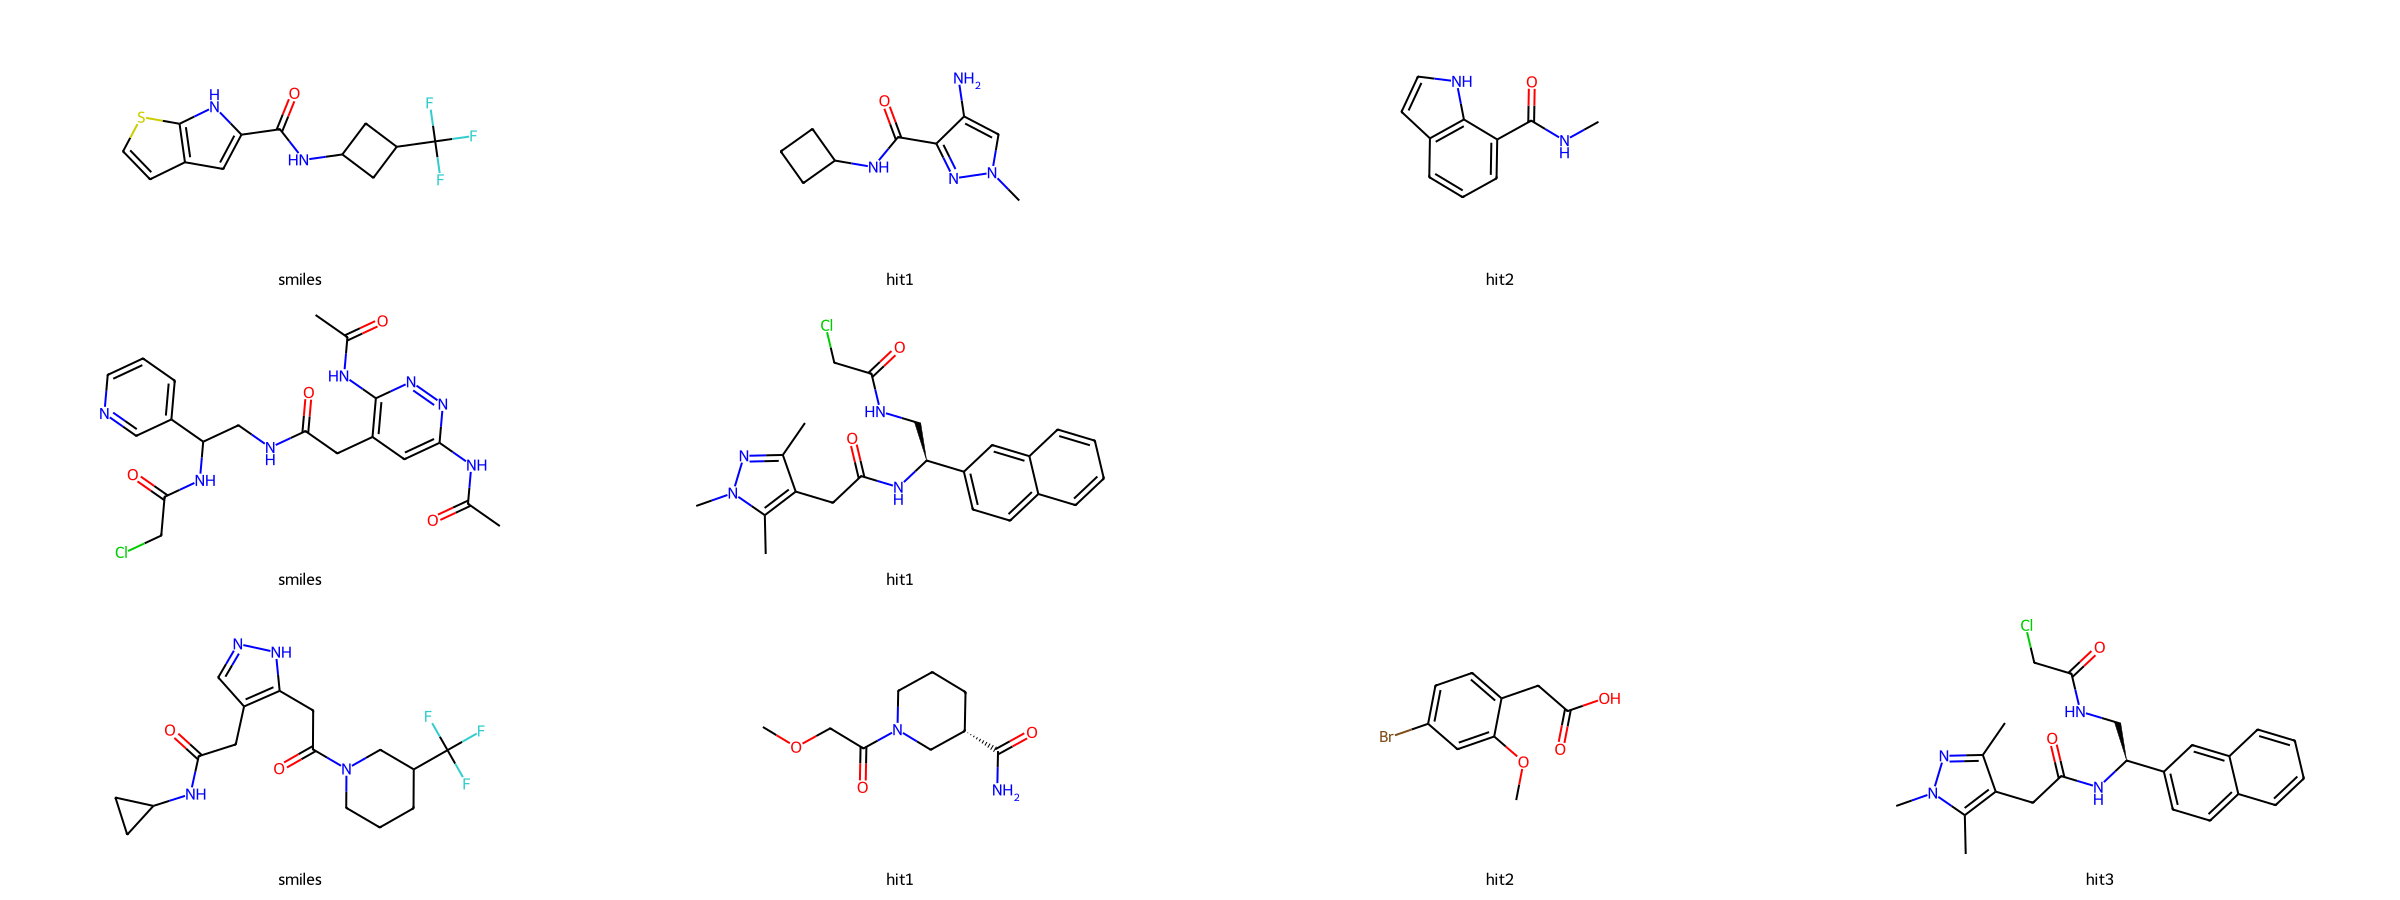

In [4]:
# Looking at the designs
from syndirella.utils.check_inputs import get_exact_hit_names
df['long_codes'] = df.apply(lambda x: get_exact_hit_names(row=x, metadata_path='fragments/metadata.csv',
                                                          hits_path='fragments/A71EV2A_combined.sdf'), axis=1)
frag_mols = Chem.SDMolSupplier('fragments/A71EV2A_combined.sdf')

mols_list = []
labels_list = []

for idx, row in df.iterrows():
    scaffold_mol = Chem.MolFromSmiles(row['smiles'])
    mols_list.append(scaffold_mol)
    labels_list.append('smiles')
    
    row_hit_mols = [frag_mol for frag_mol in frag_mols if 
                   frag_mol.GetProp('_Name') in row['long_codes']]
    # remove 3d info
    row_hit_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(frag_mol)) for frag_mol in row_hit_mols]
    
    for i in range(1, 4):
        if i <= len(row_hit_mols):
            mols_list.append(row_hit_mols[i-1])
            labels_list.append(f'hit{i}')
        else:
            mols_list.append(None)
            labels_list.append('')

Draw.MolsToGridImage(mols_list, legends=labels_list, molsPerRow=4, subImgSize=(600, 300))

## Run

In [ ]:
# Run the pipeline with absolute paths, should take ~10 minutes (specifying a reduced batch_num and atom_diff_max for example purposes)
!syndirella run -i $(pwd)/syndirella_input_example_automatic.csv -o $(pwd)/output -t $(pwd)/fragments/templates/ --hits_path $(pwd)/fragments/A71EV2A_combined.sdf --metadata $(pwd)/fragments/metadata.csv --batch_num 5 --atom_diff_max 5

## Output

The first thing you should look at after running is the output csv which contains the stats for each of the scaffold elaborations.

In [5]:
output_csv_path = glob2.glob('output/syndirella_input_example_automatic_output*')[0]
df = pd.read_csv(output_csv_path)
df

,smiles,inchi_key,error_type,error_message,retro_tool,db_search_tool,1_r1_smiles,1_r2_smiles,1_reaction,compound_set,...,hit1,hit2,hit3,num_placed,num_successful,route_uuid,template,to_hippo,total_num_products_enumstereo,total_num_unique_products
0,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N,NaN,NaN,aizynthfinder,arthor,NC1CC(C(F)(F)F)C1,O=C(O)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,syndirella_auto_1,...,A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1,A71EV2A-x0566_A_147_1_A71EV2A-x0526+A+147+1,NaN,5.0,5.0,tGXdE3,syndirella/examples/run_syndirella_example/fra...,syndirella/examples/run_syndirella_example/out...,432.0,305.0
1,CC(=O)Nc1cc(CC(=O)NCC(NC(=O)CCl)c2cccnc2)c(NC(...,RHANAJVRLKPORR-UHFFFAOYSA-N,NoSynthesisRoute,No synthesis route found by AiZynthFinder.,NaN,NaN,NaN,NaN,NaN,syndirella_auto_1,...,A71EV2A-x1346_A_250_1_A71EV2A-x0526+A+147+1,NaN,NaN,NaN,NaN,NaN,syndirella/examples/run_syndirella_example/fra...,NaN,NaN,NaN
2,O=C(Cc1cn[nH]c1CC(=O)N1CCCC(C(F)(F)F)C1)NC1CC1,QGMUJYUUQHRYMH-UHFFFAOYSA-N,NoSynthesisRoute,No synthesis route found by AiZynthFinder.,NaN,NaN,NaN,NaN,NaN,syndirella_auto_1,...,A71EV2A-x0926_A_250_1_A71EV2A-x0526+A+147+1,A71EV2A-x1346_A_250_1_A71EV2A-x0526+A+147+1,A71EV2A-x1019_A_147_1_A71EV2A-x0526+A+147+1,NaN,NaN,NaN,syndirella/examples/run_syndirella_example/fra...,NaN,NaN,NaN


From the three scaffolds elaborated, the first had a valid synthesis route and the second two did not have a synthesis route found by AiZynthFinder. You can find important things like route information and number of products. 

The final output is the `to_hippo.pkl.gz` which contains all the information to produce the elaborations. This includes, the synthesis route, placement, and other metadata. Let's look at one below.

In [6]:
# the to_hippo.pkl.gz is contained within each scaffold directory. 
to_hippo_path = 'output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/VKQJXGLAYUFNNG-UHFFFAOYSA-N_tGXdE3_to_hippo.pkl.gz'  # replace with something like this: output/OQOLMCJQPJBXLR-UHFFFAOYSA-N/OQOLMCJQPJBXLR-UHFFFAOYSA-N_b45Xnu_to_hippo.pkl.gz
df = pd.read_pickle(to_hippo_path)
df

,scaffold_smiles,1_reaction,1_r1_smiles,1_r2_smiles,1_r_previous_product,1_product_smiles,1_product_name,1_flag,1_single_reactant_elab,1_num_atom_diff,1_stereoisomer,error,∆∆G,∆G_bound,∆G_unbound,comRMSD,regarded,path_to_mol,template,intra_geometry_pass
0,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2ccsc2[nH]1,NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-scaffold-A,None,False,0,A,,-19.885515,257.335609,277.221124,0.859589,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True
1,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2ccsc2[nH]1,Cl.NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-scaffold-A,None,False,0,A,,-19.885515,257.335609,277.221124,0.859589,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True
2,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2cc(Cl)sc2[nH]1,Cl.NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2cc(Cl)sc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-1-A,None,False,1,A,,-10.528932,298.100824,308.629756,1.113295,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True
3,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1Br,Cl.NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1[nH]c2sccc2c1Br,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-2-A,None,False,1,A,,-17.573608,265.200929,282.774536,0.944092,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True
4,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1Br,NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1[nH]c2sccc2c1Br,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-2-A,None,False,1,A,,-17.573608,265.200929,282.774536,0.944092,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1F,NC1CC(F)(C(F)(F)F)C12CCC2,None,O=C(N[C@@H]1C[C@](F)(C(F)(F)F)C12CCC2)c1[nH]c2...,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-304-A,None,False,5,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fragments/templates/Ax0310a_apo-desolv.pdb,NaN
609,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1F,NC1CC(F)(C(F)(F)F)C12CCC2,None,O=C(N[C@H]1C[C@](F)(C(F)(F)F)C12CCC2)c1[nH]c2s...,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-304-B,None,False,5,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fragments/templates/Ax0310a_apo-desolv.pdb,NaN
610,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1F,NC1CC(F)(C(F)(F)F)C12CCC2,None,O=C(N[C@@H]1C[C@@](F)(C(F)(F)F)C12CCC2)c1[nH]c...,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-304-C,None,False,5,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fragments/templates/Ax0310a_apo-desolv.pdb,NaN
611,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1F,NC1CC(F)(C(F)(F)F)C12CCC2,None,O=C(N[C@H]1C[C@@](F)(C(F)(F)F)C12CCC2)c1[nH]c2...,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-304-D,None,False,5,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fragments/templates/Ax0310a_apo-desolv.pdb,NaN


In [7]:
# Looking at the results
placed = df[df['∆∆G'].notna()]
placed['acceptable'] = (placed['∆∆G'] < 0) & (placed['comRMSD'] < 2.0) & (placed['intra_geometry_pass'])
placed['acceptable'].value_counts()

/var/folders/sg/gb03t0zx5sz8vw2lxlghz1gr0000gn/T/ipykernel_62430/2724219223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placed['acceptable'] = (placed['∆∆G'] < 0) & (placed['comRMSD'] < 2.0) & (placed['intra_geometry_pass'])


acceptable
True    10
Name: count, dtype: int64

Out of the 10 elaborated designs energy minimized, 100% passed the usual filters of `∆∆G < 0 & comRMSD < 2.0 & passed intramolecular geometry checks`.

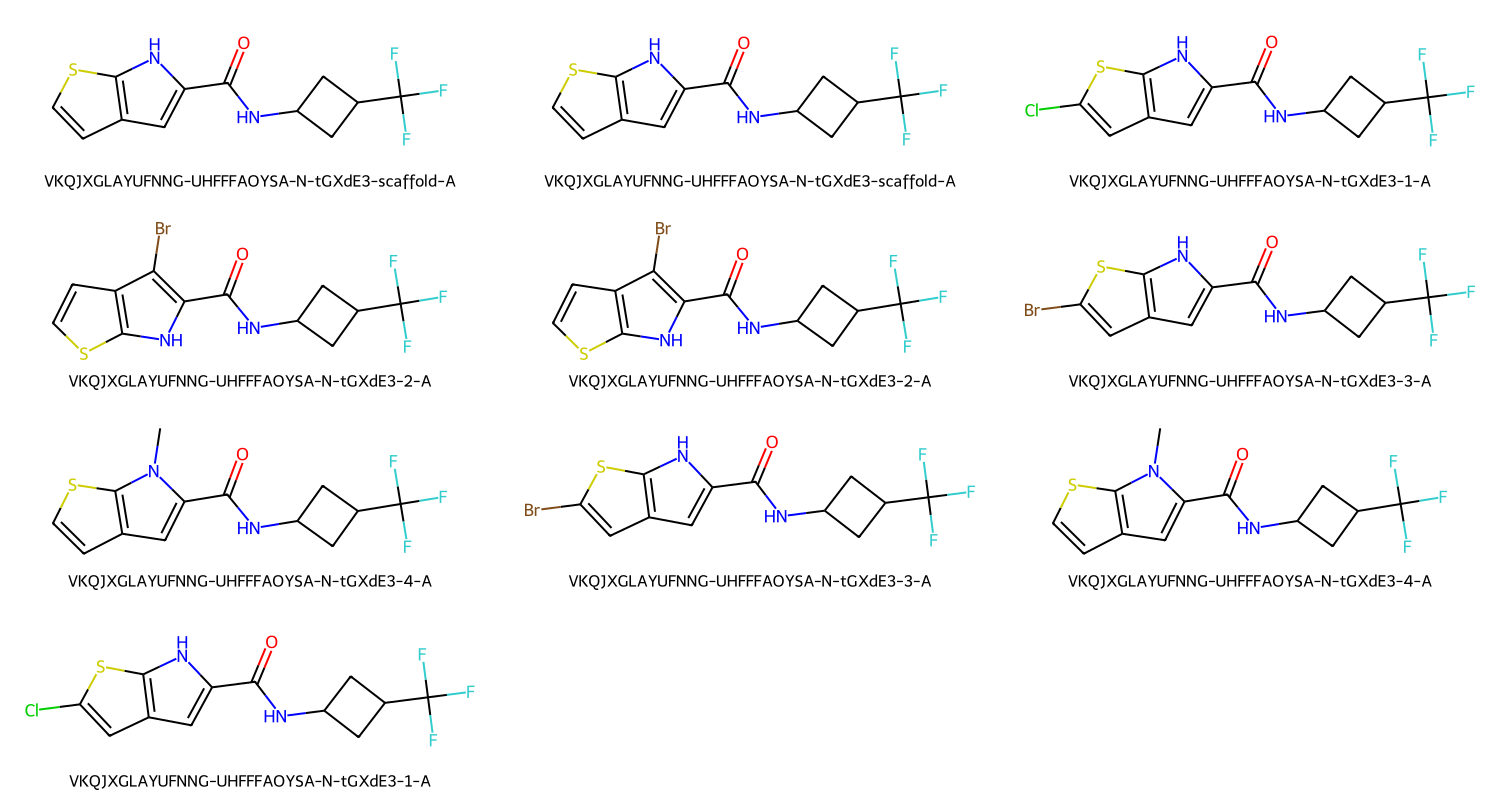

In [8]:
accept_df = placed[placed['acceptable']]
passing_mols = [Chem.MolFromSmiles(smiles) for smiles in accept_df['1_product_smiles']]
legends = accept_df['1_product_name'].tolist()
Draw.MolsToGridImage(passing_mols, legends=legends, molsPerRow=3, subImgSize=(500, 200))

Notice there are repeated products, but looking more closely at their routes they are different. This is due to the salt form of reactants returned by Arthor in `1_r2_smiles`.

In [9]:
accept_df

,scaffold_smiles,1_reaction,1_r1_smiles,1_r2_smiles,1_r_previous_product,1_product_smiles,1_product_name,1_flag,1_single_reactant_elab,1_num_atom_diff,...,error,∆∆G,∆G_bound,∆G_unbound,comRMSD,regarded,path_to_mol,template,intra_geometry_pass,acceptable
0,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2ccsc2[nH]1,NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-scaffold-A,None,False,0,...,,-19.885515,257.335609,277.221124,0.859589,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
1,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2ccsc2[nH]1,Cl.NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-scaffold-A,None,False,0,...,,-19.885515,257.335609,277.221124,0.859589,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
2,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2cc(Cl)sc2[nH]1,Cl.NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2cc(Cl)sc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-1-A,None,False,1,...,,-10.528932,298.100824,308.629756,1.113295,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
3,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1Br,Cl.NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1[nH]c2sccc2c1Br,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-2-A,None,False,1,...,,-17.573608,265.200929,282.774536,0.944092,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
4,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1[nH]c2sccc2c1Br,NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1[nH]c2sccc2c1Br,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-2-A,None,False,1,...,,-17.573608,265.200929,282.774536,0.944092,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
5,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2cc(Br)sc2[nH]1,NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2cc(Br)sc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-3-A,None,False,1,...,,-6.471210,298.691023,305.162233,1.128438,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
6,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,Cn1c(C(=O)O)cc2ccsc21,Cl.NC1CC(C(F)(F)F)C1,None,Cn1c(C(=O)NC2CC(C(F)(F)F)C2)cc2ccsc21,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-4-A,None,False,1,...,,-3.670712,288.510486,292.181198,1.134388,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
7,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,O=C(O)c1cc2cc(Br)sc2[nH]1,Cl.NC1CC(C(F)(F)F)C1,None,O=C(NC1CC(C(F)(F)F)C1)c1cc2cc(Br)sc2[nH]1,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-3-A,None,False,1,...,,-6.471210,298.691023,305.162233,1.128438,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",output/VKQJXGLAYUFNNG-UHFFFAOYSA-N/output/outp...,fragments/templates/Ax0310a_apo-desolv.pdb,True,True
8,O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1,Carboxylic_acid_with_primary_amine_to_amide,Cn1c(C(=O)O)cc2ccsc21,NC1CC(C(F)(F)F)C1,None,Cn1c(C(=O)NC2CC(C(F)(F)F)C2)cc2ccsc21,VKQJXGLAYUFNNG-UHFFFAOYSA-N-tGXdE3-4-A,None,False,1,...,,-3.670712,288.510486,292.181198,1.134388,"[A71EV2A-x0556_A_147_1_A71EV2A-x0526+A+147+1, ...",out